In [1]:
import jax
from jax import numpy as jnp
jax.config.update("jax_enable_x64", True)
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib.animation import FFMpegWriter
from functools import lru_cache
from typing import Callable

In [2]:
class Sperm2D:
    def __init__(self,
                 length: float = 65.0,
                 n_segments: int = 50,
                 bending_modulus: float = 1800.0,
                 amplitude: float = 0.2,
                 wavenumber: float = 1.0,
                 frequency: float = 1.0,
                 phase: float = 0.0,
                 init_position: jnp.ndarray = jnp.array([0.0, 0.0]),
                 init_angle: float = 0.0,
                 head_semi_major: float = 3.0,
                 tail_radius: float = 1.0):
        """
        Initialize a single 2D sperm filament.

        Parameters
        ----------
        length : Total length of the filament (L).
        n_segments : Number of discrete segments (N).
        bending_modulus : Bending stiffness K_B.
        amplitude, wavenumber, frequency, phase : Parameters for the preferred-curvature waveform kappa(s,t).
        init_position : Initial position of the head tip of sperm
        init_angle: Initial angle of the sperm
        head_semi_major, tail_radius: radius of head and flagellum segments
        """
        # Geometry & discretization
        self.L       = length
        self.N_flag  = n_segments
        self.dL      = length / n_segments
        self.a       = head_semi_major
        self.b       = tail_radius

        # radii and segment lengths as JAX arrays
        self.radii   = jnp.concatenate([jnp.array([self.a]),
                                        jnp.full(self.N_flag, self.b)])
        self.lengths = jnp.concatenate([jnp.array([2*self.a]),
                                        jnp.full(self.N_flag, self.dL)])

        # Mechanical parameters
        self.K_B  = bending_modulus
        self.K0   = amplitude
        self.k    = wavenumber
        self.omega = frequency
        self.phi = phase

        # Precompute segment "s" coordinates for preferred curvature
        self.s_mid = jnp.arange(self.dL/2,
                            self.L,
                            self.dL) # shape (N_flag, )

        # midpoint position and angle of each segment including head
        all_coords = jnp.concatenate([
            jnp.array([self.a]),
            self.s_mid + 2.1*self.a
        ])
        self.Y = jnp.stack([
            init_position[0] + all_coords * jnp.cos(init_angle),
            init_position[1] + all_coords * jnp.sin(init_angle)
        ], axis=1)                       # shape (N_flag+1, 2)
        self.thetas = jnp.full(self.N_flag+1, init_angle)
        
        # Lagrange multipliers for N_flag+2 constraints
        self.Lambdas = jnp.zeros((self.N_flag+2, 2), )

    @partial(jax.jit, static_argnums=(0,))
    def preferred_curvature(self, t: float) -> jnp.ndarray: # shape (N_flag, )
        """
        Calculate the curvature at midpoints of each flagellum segment, head exclusive.

        Parameters
        ----------
        t : time

        Returns
        -------
        kappa : curvature
        """
        base  = self.K0 * jnp.sin(2*jnp.pi*self.k*self.s_mid/self.L
                                  - self.omega*t + self.phi)
        decay = jnp.where(self.s_mid > self.L/2,
                          1.0,
                          2*self.s_mid/self.L)
        return base * decay

    @partial(jax.jit, static_argnums=(0,))
    def internal_moment(self,
                        theta: jnp.ndarray,   # shape (N_flag+1, )
                        t: float) -> jnp.ndarray: # shape (N_flag+2, )
        """
        Calculate the internal moments at the edge of each segment, head inclusive.

        Parameters
        ----------
        theta : angle at the midpoint of each segment
        t : time

        Returns
        -------
        M : internal moments at segment edges
        """
        kappa = self.preferred_curvature(t)                 # (N_flag, )
        t_hat = jnp.stack([jnp.cos(theta), jnp.sin(theta)], axis=1)  # (N_flag+1, 2)

        # cross product z‐component: t_i × t_{i+1}
        cross = (t_hat[:-1,0]*t_hat[1:,1]
                 - t_hat[:-1,1]*t_hat[1:,0])           # (N_flag, )

        # delta_s for each edge
        delta_s = jnp.concatenate([jnp.array([1.1*self.a+0.5*self.L]),
                                    jnp.full(self.N_flag-1, self.dL)]) # (N_flag, )

        # build M: zeros at boundaries, use vector ops
        M_mid = self.K_B * (cross / delta_s - kappa)    # (N_flag, )
        return jnp.concatenate([jnp.array([0.0]),
                                M_mid,
                                jnp.array([0.0])])  # (N_flag+2,)

    @partial(jax.jit, static_argnums=(0,))
    def reconstruct_midpoints(self,
                              Y1: jnp.ndarray,    # shape (2, )
                              theta: jnp.ndarray      # shape (N_flag+1, )
                              ) -> jnp.ndarray:    # returns (N_flag+1, 2)
        """
        Calculate the midpoint positions of each segment from its angle and the head midpoint position.
    
        Parameters
        ----------
        Y1 : coordinates of the head midpoint
        theta : angle at the midpoint of each segment
    
        Returns
        -------
        Y : midpoint coordinates of each segment
        """
        t_hat = jnp.stack([jnp.cos(theta), jnp.sin(theta)], axis=1)  # (N+1, 2)

        # head-tail and tail-tail displacements
        disp = jnp.vstack([Y1[None, :],
                           (1.1*self.a*t_hat[0] + 0.5*self.dL*t_hat[1])[None, :],
                           0.5*self.dL*(t_hat[1:-1]+t_hat[2:])]) # (N+1, 2)

        return jnp.cumsum(disp, axis=0)               # (N+1,2)

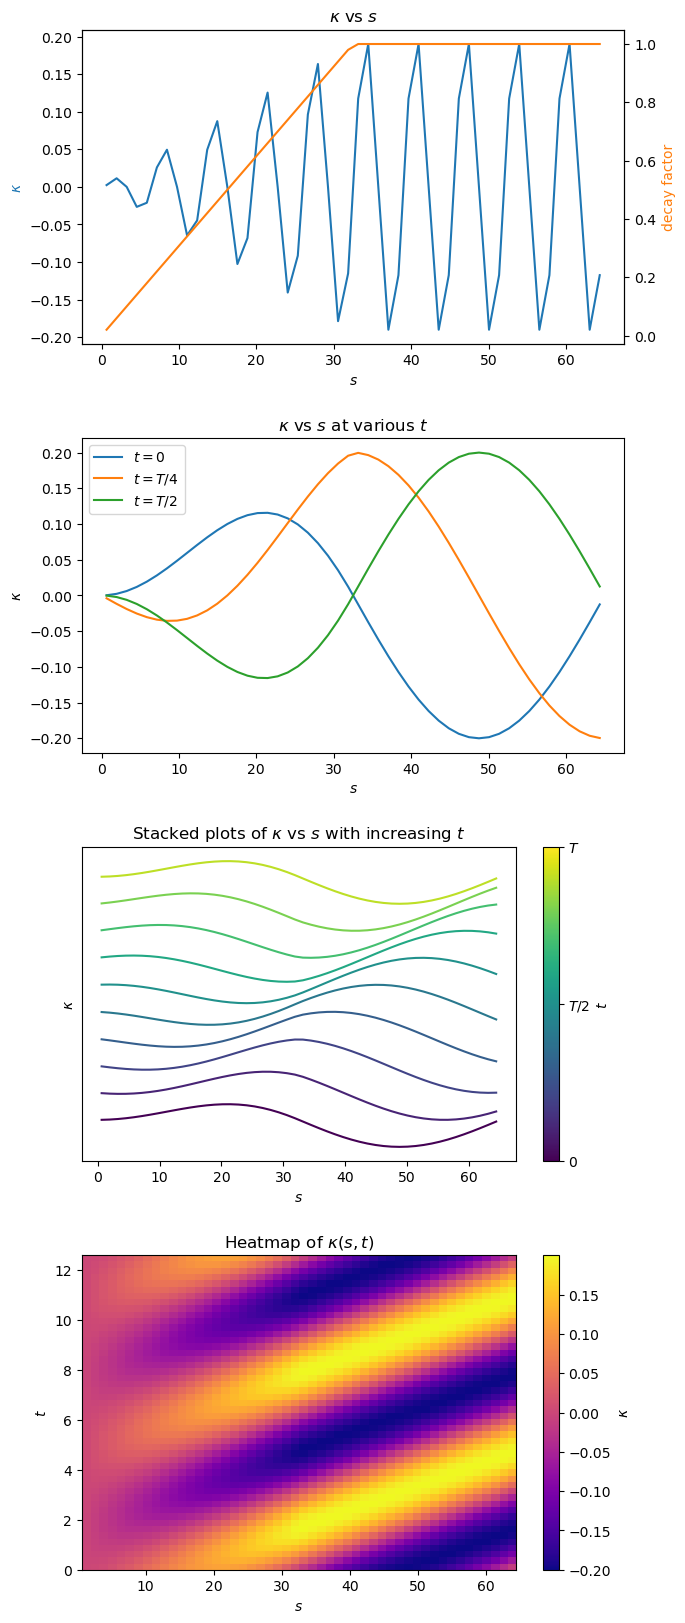

In [3]:
# Check preferred_curvature method
fig, ax = plt.subplots(4, figsize=(7, 20))
plt.subplots_adjust(hspace=0.3)

# Check decay factor
sperm = Sperm2D(wavenumber=10)
kappa = sperm.preferred_curvature(0)
decay = jnp.where(sperm.s_mid > sperm.L/2,
                  1.0,
                  2*sperm.s_mid/sperm.L)
ax[0].plot(sperm.s_mid, kappa)
ax[0].set_title(r'$\kappa$ vs $s$')
ax[0].set_xlabel(r'$s$')
ax[0].set_ylabel(r'$\kappa$', color='C0')
ax1_2 = ax[0].twinx()
ax1_2.plot(sperm.s_mid, decay, label='decay factor', c='C1')
ax1_2.set_ylabel('decay factor', color='C1')

# Different t
sperm = Sperm2D()
T = 2*jnp.pi/sperm.omega
label_list = ['0', 'T/4', 'T/2']
for i in range(3):
    t = i*T/4
    kappa = sperm.preferred_curvature(t)
    ax[1].plot(sperm.s_mid, kappa, label=f"$t={label_list[i]}$")
    ax[1].set_title(r'$\kappa$ vs $s$ at various $t$')
    ax[1].set_xlabel(r'$s$')
    ax[1].set_ylabel(r'$\kappa$')
    ax[1].legend()

# Stacked plots of kappa vs s for various t
T = 2*jnp.pi / sperm.omega    
n_times = 10                 
times = np.linspace(0, T, n_times)
offset = 0.2                  
for i in range(n_times):
    kappa = sperm.preferred_curvature(times[i])
    ax[2].plot(sperm.s_mid, kappa+i*offset, color=plt.cm.viridis(i/n_times))    
ax[2].set_xlabel(r'$s$')
ax[2].set_ylabel(r"$\kappa$")
ax[2].set_yticks([])
ax[2].set_title(r"Stacked plots of $\kappa$ vs $s$ with increasing $t$")
cmap = plt.cm.ScalarMappable(
    cmap='viridis')
cmap.set_array([])
ticks = [0, r'$T/2$', r'$T$']
cbar = fig.colorbar(cmap, ax=ax[2], ticks=[0, 0.5, 1])
cbar.set_label(r'$t$')
cbar.set_ticklabels(['0', r'$T/2$', r'$T$'])

# 2D heatmap of kappa(s, t)
T    = 2*np.pi/sperm.omega
n_t  = sperm.s_mid.shape[0]
times = np.linspace(0, 2*T, n_t)
kappa_array = np.vstack([sperm.preferred_curvature(t).block_until_ready() for t in times])
im = ax[3].imshow(
    kappa_array,
    extent=[sperm.s_mid[0], sperm.s_mid[-1], times[0], times[-1]],
    cmap='plasma',
    aspect='auto',
    origin='lower'
)
ax[3].set_xlabel(r'$s$')
ax[3].set_ylabel(r'$t$')
ax[3].set_title(r'Heatmap of $\kappa(s,t)$')
cbar = fig.colorbar(im, ax=ax[3])
cbar.set_label(r'$\kappa$')

plt.show()

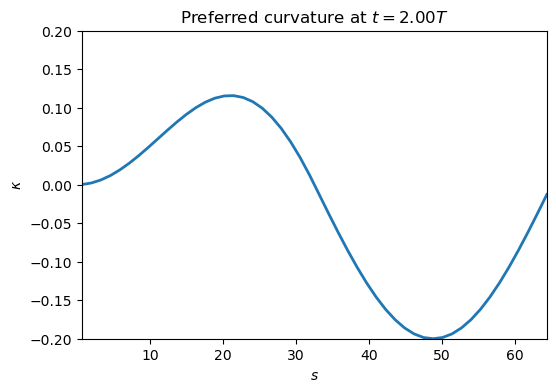

In [4]:
# Animate the data from 2D heatmap of kappa
fig, ax = plt.subplots(figsize=(6,4))
ax.set_xlim(sperm.s_mid[0], sperm.s_mid[-1])
ax.set_ylim(-sperm.K0, sperm.K0)
ax.set_xlabel(r'$s$')
ax.set_ylabel(r'$\kappa$')

line, = ax.plot([], [], lw=2)
title = ax.set_title('')

def init():
    line.set_data([], [])
    return (line, title)

def animate(i):
    line.set_data(sperm.s_mid, kappa_array[i])
    title.set_text(f'Preferred curvature at $t={times[i]/T:.2f}T$')
    return (line, title)

ani = animation.FuncAnimation(
    fig, animate, init_func=init,
    frames=len(times), interval=100, blit=True
)

writer = FFMpegWriter(
    fps=10,
    metadata=dict(title='kappa vs s with increasing t'),
    bitrate=1800
)

ani.save('kappa_s_t.mp4', writer=writer, dpi=200)

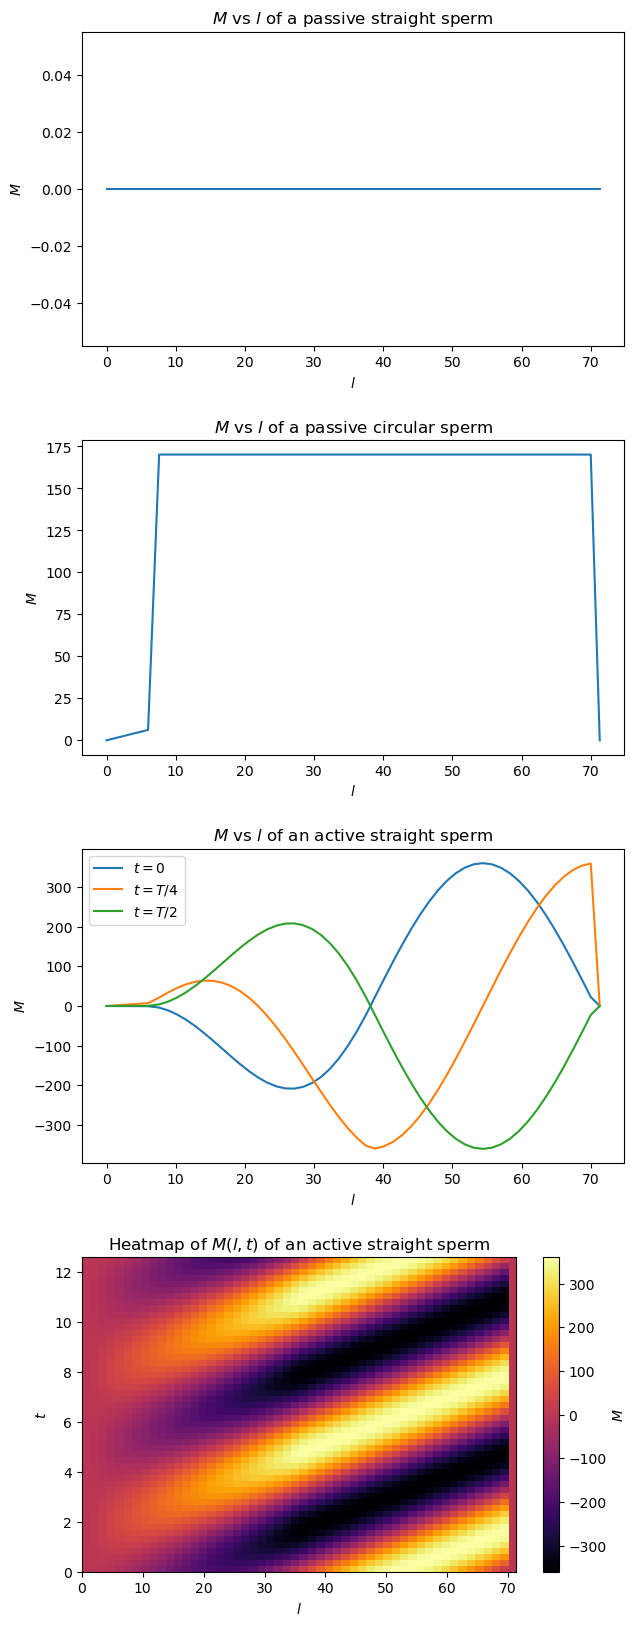

In [5]:
# Check internal_moment method
fig, ax = plt.subplots(4, figsize=(7, 20))
plt.subplots_adjust(hspace=0.3)

# Passive straight sperm
sperm = Sperm2D(amplitude=0)
l = jnp.concatenate([jnp.array([0.0, 2*sperm.a]),
                     jnp.arange(2.1*sperm.a+sperm.dL, 2.1*sperm.a+sperm.L+sperm.dL, sperm.dL)])
M = sperm.internal_moment(sperm.thetas, 0)
ax[0].plot(l, M)
ax[0].set_title(r'$M$ vs $l$ of a passive straight sperm')
ax[0].set_xlabel(r'$l$')
ax[0].set_ylabel(r'$M$')

# Passive circular sperm
sperm.thetas = jnp.linspace(0, 2*np.pi, sperm.thetas.shape[0], endpoint=False)
M = sperm.internal_moment(sperm.thetas, 0)
ax[1].plot(l, M)
ax[1].set_title(r'$M$ vs $l$ of a passive circular sperm')
ax[1].set_xlabel(r'$l$')
ax[1].set_ylabel(r'$M$')

# Active straight sperm at different times
sperm = Sperm2D()
T = 2*jnp.pi/sperm.omega
label_list = ['0', 'T/4', 'T/2']
for i in range(3):
    t = i*T/4
    M = sperm.internal_moment(sperm.thetas, t)
    ax[2].plot(l, M, label=f'$t={label_list[i]}$')
ax[2].set_title(r'$M$ vs $l$ of an active straight sperm')
ax[2].set_xlabel(r'$l$')
ax[2].set_ylabel(r'$M$')
ax[2].legend()

# 2D heatmap of M(s, t) of an active straight sperm
T    = 2*np.pi/sperm.omega
n_t  = l.shape[0]
times = np.linspace(0, 2*T, n_t)
M_array = np.vstack([sperm.internal_moment(sperm.thetas, t).block_until_ready() for t in times])
im = ax[3].imshow(
    M_array,
    extent=[l[0], l[-1], times[0], times[-1]],
    cmap='inferno',
    aspect='auto',
    origin='lower'
)
ax[3].set_xlabel(r'$l$')
ax[3].set_ylabel(r'$t$')
ax[3].set_title(r'Heatmap of $M(l,t)$ of an active straight sperm')
cbar = fig.colorbar(im, ax=ax[3])
cbar.set_label(r'$M$')

plt.show()

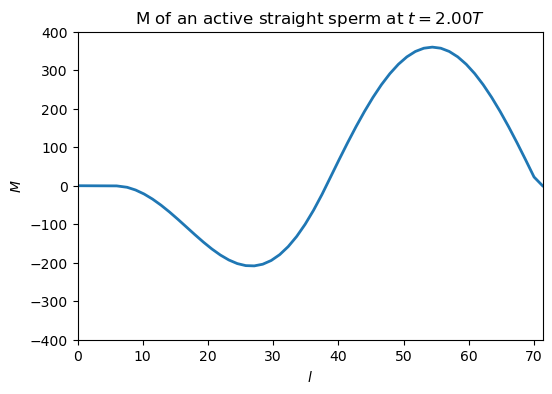

In [6]:
# Animate the data from 2D heatmap
fig, ax = plt.subplots(figsize=(6,4))
ax.set_xlim(l[0], l[-1])
ax.set_ylim(-400, 400)
ax.set_xlabel(r'$l$')
ax.set_ylabel(r'$M$')

line, = ax.plot([], [], lw=2)
title = ax.set_title('')

def init():
    line.set_data([], [])
    return (line, title)

def animate(i):
    line.set_data(l, M_array[i])
    title.set_text(f'M of an active straight sperm at $t={times[i]/T:.2f}T$')
    return (line, title)

ani = animation.FuncAnimation(
    fig, animate, init_func=init,
    frames=len(times), interval=100, blit=True
)

writer = FFMpegWriter(
    fps=10,
    metadata=dict(title='M vs l of an active straight sperm with increasing t'),
    bitrate=1800
)

ani.save('M_l_t.mp4', writer=writer, dpi=200)

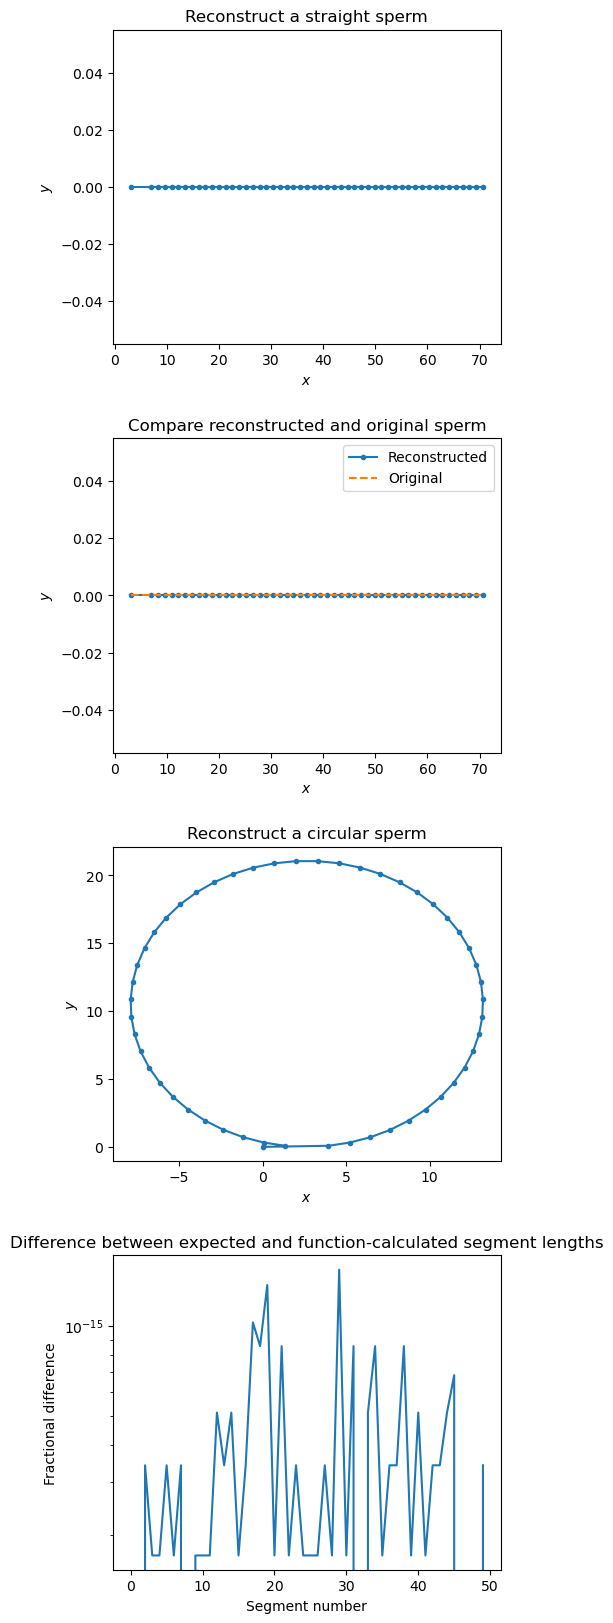

In [7]:
# Check reconstruct_midpoints method
fig, ax = plt.subplots(4, figsize=(5, 20))
plt.subplots_adjust(hspace=0.3)

# Reconstruct a straight sperm
sperm = Sperm2D()
Y = sperm.reconstruct_midpoints(jnp.array([sperm.a,0.0]), jnp.zeros(sperm.N_flag+1))
ax[0].plot(Y[:,0], Y[:,1], '.-')
ax[0].set_title("Reconstruct a straight sperm")
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$y$')

# Check reconstructed vs original sperm
ax[1].plot(Y[:,0], Y[:,1], '.-', label='Reconstructed')
ax[1].plot(sperm.Y[:, 0], sperm.Y[:, 1], '--', label='Original')
ax[1].legend()
ax[1].set_title("Compare reconstructed and original sperm")
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$y$')

# Reconstruct a circular sperm
sperm.thetas = jnp.linspace(0, 2*jnp.pi, sperm.thetas.shape[0], endpoint=False)
Y = sperm.reconstruct_midpoints(jnp.array([0.0,0.0]), sperm.thetas)
ax[2].plot(Y[:,0], Y[:,1], '.-')
ax[2].set_title("Reconstruct a circular sperm")
ax[2].set_xlabel(r'$x$')
ax[2].set_ylabel(r'$y$')

# Check segment length of the circular sperm
# Check segment length of the circular sperm
dists = jnp.linalg.norm(jnp.diff(Y, axis=0), axis=1)
angle = jnp.pi/sperm.thetas.shape[0]
head_tail = ((1.1*sperm.a)**2 + (0.5*sperm.dL)**2 + 1.1*sperm.a*sperm.dL*jnp.cos(2*angle))**0.5
actual = jnp.concatenate([jnp.array([head_tail]), jnp.full(sperm.N_flag-1, sperm.dL*jnp.cos(angle))])
frac_diff = jnp.abs(dists - actual)/actual
ax[3].plot(frac_diff)
ax[3].set_yscale('log')
ax[3].set_title("Difference between expected and function-calculated segment lengths")
ax[3].set_xlabel('Segment number')
ax[3].set_ylabel('Fractional difference')

plt.show()

In [8]:
sperm = Sperm2D()
theta_array = jnp.array([jnp.linspace(0, i*jnp.pi/25, sperm.thetas.shape[0], endpoint=False) for i in range(51)])
Y_array = jnp.array([sperm.reconstruct_midpoints(jnp.array([0.0, 0.0]), theta_array[i]) for i in range(51)])

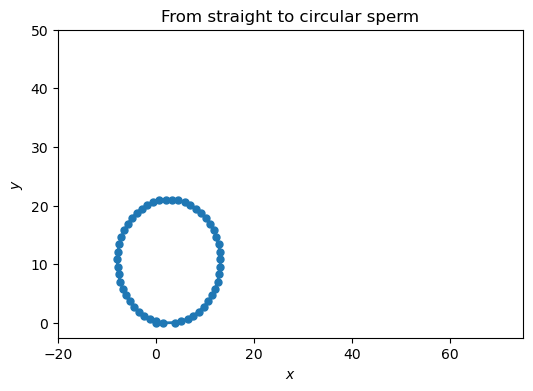

In [9]:
# Check reconstruct_midpoints with time-varying angle
fig, ax = plt.subplots(figsize=(6,4))
ax.set_xlim(-20, 75)
ax.set_ylim(-2.5, 50)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

line, = ax.plot([], [], 'o-',  # 'o-' = circle markers + solid line
                lw=2,          # Line width
                markersize=5)  # Marker size
title = ax.set_title('')

def init():
    line.set_data([], [])
    return (line, title)

def animate(i):
    line.set_data(Y_array[i][:, 0], Y_array[i][:, 1])
    title.set_text(f'From straight to circular sperm')
    return (line, title)

ani = animation.FuncAnimation(
    fig, animate, init_func=init,
    frames=len(times), interval=100, blit=True
)

writer = FFMpegWriter(
    fps=10,
    metadata=dict(title='Straight to circular sperm'),
    bitrate=1800
)

ani.save('straight_circle.mp4', writer=writer, dpi=200)

In [10]:
@jax.jit
def barrier_force(positions: jnp.ndarray,   # (N_flag+1, 2)
                  radii:     jnp.ndarray,   # (N_flag, )
                  F_S:       float,
                  chi:       float) -> jnp.ndarray:  # returns (N_flag+1,2)
    """
    Calculate steric repulsion (barrier) force.

    Parameters
    ----------
    positions : segment midpoints
    radii : segment radii
    F_S : scalar force strength
    chi : range factor

    Returns
    -------
    F_B : Steric repulsion force experienced by each segment
    """
    N = positions.shape[0]
    
    # Precompute pair indices i<j
    i_idx, j_idx = jnp.triu_indices(N, k=1)

    # Vector differences and distances
    diffs   = positions[i_idx] - positions[j_idx]      # (M, 2)
    d2      = jnp.sum(diffs**2, axis=1)                # (M, )
    dist = d2**0.5 # (M, )

    # Contacts and thresholds
    contact = radii[i_idx] + radii[j_idx]              # (M,)
    r_thr   = chi * contact                            # (M,)
    chi2m1  = chi*chi - 1.0

    # Mask: not neighbors (|i-j|>1) & within threshold
    mask = (j_idx - i_idx > 1) & (dist < r_thr)

    # Compute mag only where mask is True
    num   = r_thr**2 - d2
    denom = (contact**2) * chi2m1
    mag   = F_S * (num/denom)**4 / contact             # (M,)
    mag   = mag * mask                                # zero out unwanted pairs

    # Per‑pair force vectors
    F_pair = diffs * mag[:, None]                      # (M,2)

    # Initialize zero forces
    F_B = jnp.zeros_like(positions)                    # (N,2)

    # Scatter-add: +F_pair on i, -F_pair on j
    F_B = F_B.at[i_idx].add(F_pair)
    F_B = F_B.at[j_idx].add(-F_pair)

    return F_B

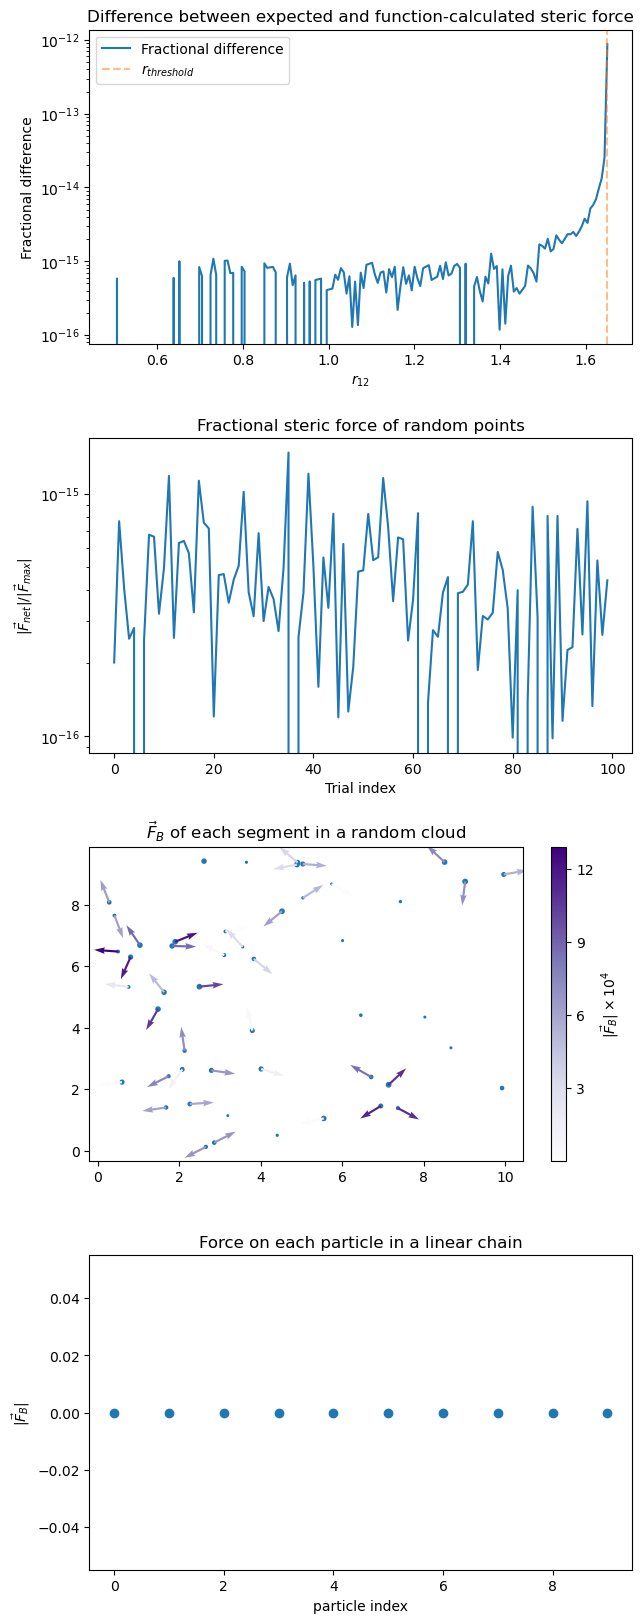

In [11]:
# Check barrier_force function
fig, ax = plt.subplots(4, figsize=(7, 20))
plt.subplots_adjust(hspace=0.3)

# Two-body test
F_S = 300
chi = 1.1
r_1, r_2 = 0.5, 1
contact = r_1 + r_2
r_thr   = chi*contact
ds = jnp.linspace(r_2-r_1, 1.1*r_thr, 200)
mask    = ds < r_thr
num   = r_thr**2 - ds**2
denom = (contact**2)*(chi**2-1)
F_analytic = F_S*(num/denom)**4 / contact * ds * mask
F_num = jnp.array([barrier_force(jnp.array([[0, 0], [0, 0], [ds[i], 0]]),
                                jnp.array([r_1, r_1, r_2]),
                                F_S,
                                chi)[-1, 0] for i in range(200)])
frac_diff = jnp.abs(F_num-F_analytic)/F_analytic
ax[0].plot(ds, frac_diff, label='Fractional difference')
ax[0].axvline(r_thr, label=r'$r_{threshold}$', alpha=0.5, c='C1', ls='dashed')
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_title("Difference between expected and function-calculated steric force")
ax[0].set_xlabel(r'$r_{12}$')
ax[0].set_ylabel('Fractional difference')

# Random cloud test for magnitude
N = 50
n_trial = 100
F_mag_array = jnp.zeros(n_trial)
for i in range(n_trial):
    key_1 = jax.random.key(i)
    pos = jax.random.uniform(key_1, shape=(N, 2), minval=0, maxval=10)
    key_2, key_3 = jax.random.split(key_1)
    radii = jax.random.uniform(key_2, shape=(N, ), minval=0.1, maxval=1)
    F = barrier_force(pos, radii, F_S, chi)
    F_net = jnp.sum(F, axis=0)
    F_mag_array = F_mag_array.at[i].set((F_net[0]**2 + F_net[1]**2)**0.5/jnp.max(F))
ax[1].plot(F_mag_array)
ax[1].set_yscale('log')
ax[1].set_title("Fractional steric force of random points")
ax[1].set_xlabel("Trial index")
ax[1].set_ylabel(r'$|\vec{F}_{net}|/|\vec{F}_{max}|$')

# Random cloud test for direction
key_1 = jax.random.key(100)
pos = jax.random.uniform(key_1, shape=(N, 2), minval=0, maxval=10)
key_2, key_3 = jax.random.split(key_1)
radii = jax.random.uniform(key_2, shape=(N, ), minval=0.1, maxval=1)
F_B = barrier_force(pos, radii, F_S, chi)
mag = jnp.sqrt(F_B[:, 0]**2+F_B[:, 1]**2)
mask = mag > 0
F_B_hat_x = F_B[:,0][mask] / mag[mask]
F_B_hat_y = F_B[:,1][mask] / mag[mask]
ax[2].scatter(pos[:,0], pos[:,1], s=radii*10)
Q = ax[2].quiver(pos[:,0][mask], pos[:,1][mask],
                 F_B_hat_x, F_B_hat_y,
                 mag[mask],
                 angles='xy', 
                 cmap='Purples',
                 width=0.005)
ax[2].set_title(r"$\vec{F}_B$ of each segment in a random cloud")
cbar = fig.colorbar(Q, ax=ax[2], label=r'$|\vec{F}_B|\times 10^4$', ticks=[3e4*i for i in range(6)])
cbar.set_ticklabels([str(3*i) for i in range(6)])

# Check for the skipping of immediate neighbours
N = 10
r = 0.4
ds = 0.9*chi*2*r
pos = jnp.stack([jnp.arange(0, N*ds, ds), jnp.zeros(N)], axis=1)
radii = jnp.full(N, r)
F_B = barrier_force(pos, radii, F_S, chi)
mag = jnp.sqrt(F_B[:, 0]**2+F_B[:, 1]**2)
ax[3].plot(mag, 'o')
ax[3].set_xlabel("particle index")
ax[3].set_ylabel(r"$|\vec{F}_B|$")
ax[3].set_title("Force on each particle in a linear chain")

plt.show()

In [12]:
@jax.jit
def constraint_force(Lambda: jnp.ndarray # (N_flag+2, 2)
                     ) -> jnp.ndarray: # (N_flag+1, 2)
    """
    Compute the constraint forces at each segment midpoint from the
    edge Lagrange multipliers.

    Parameters
    ----------
    Lambda : Internal (edge) forces, with free‑end conditions implying 
             Lambda[0] = Lambda[N_flag+2] = 0

    Returns
    -------
    F_C : Constraint forces at segment midpoints.
    """
    # Equivalent to Lambda[1:] - Lambda[:-1]
    return jnp.diff(Lambda, axis=0)

In [13]:
def elastic_torque(M: jnp.ndarray # (N_flag+2, )
                  ) -> jnp.ndarray: # (N_flag+1, )
    """
    Compute the elastic torque at each segment midpoint from the
    edge bending moments.

    Parameters
    ----------
    M : Bending moments at the edges (with M[0]=M[N+1]=0 by BC).

    Returns
    -------
    T_E : Elastic torques at the midpoints: M[1:] - M[:-1].
    """
    return jnp.diff(M)

In [14]:
@jax.jit
def constraint_torque(Lambda: jnp.ndarray,   # (N_flag+2, 2)
                      angles: jnp.ndarray,   # (N_flag+1,)
                      lengths: jnp.ndarray   # (N_flag+1,)
                     ) -> jnp.ndarray:      # (N_flag+1,)
    """
    Compute the constraint torques at each segment midpoint from the
    Lagrange multipliers on the segment edges.

    Parameters
    ----------
    Lambda : Constraint multipliers at edges (head…tail).
    angles : Tangent angles at each segment midpoint.
    lengths: Length of each segment.

    Returns
    -------
    T_C : Scalar constraint torque on each segment midpoint.
    """
    # Sum the two Lambdas flanking each midpoint: shape (N_flag+1,2)
    lam_sum = Lambda[:-1] + Lambda[1:]  

    # Unit tangent components at each midpoint
    t_x = jnp.cos(angles)
    t_y = jnp.sin(angles)

    # 2D cross product (t × lam_sum)_z = t_x*lam_y - t_y*lam_x
    torque_scalar = t_x * lam_sum[:,1] - t_y * lam_sum[:,0]

    # Multiply by half the segment length
    return 0.5 * lengths * torque_scalar

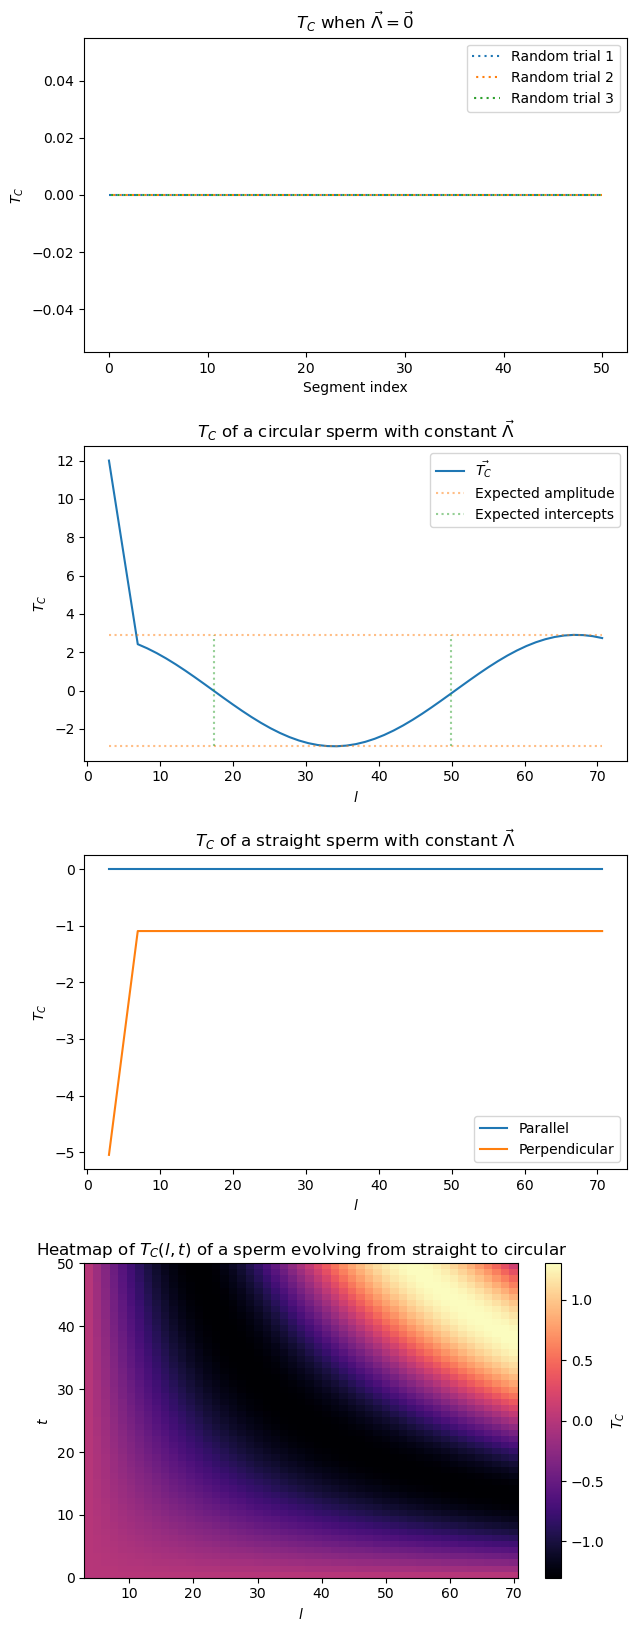

In [15]:
# Check constraint_torque function
fig, ax = plt.subplots(4, figsize=(7, 20))
plt.subplots_adjust(hspace=0.3)

# Zero-lambda test
N = 50
Lambda = jnp.zeros((N+2, 2))
for i in range(3):
    key_1 = jax.random.key(i)
    angles = jax.random.uniform(key_1, shape=(N+1, ), minval=0, maxval=2*jnp.pi)
    key_2, key_3 = jax.random.split(key_1)
    lengths = jax.random.uniform(key_2, shape=(N+1, ), minval=0.1, maxval=1)
    ax[0].plot(constraint_torque(Lambda,
                                angles,
                                lengths),
              linestyle=(i, (1, 2)),
              label=f"Random trial {i+1}")
ax[0].legend()
ax[0].set_title(r"$T_C$ when $\vec{\Lambda}=\vec{0}$")
ax[0].set_xlabel('Segment index')
ax[0].set_ylabel(r'$T_C$')

# Constant Lambda throughout a circular sperm
sperm = Sperm2D()
A, B = 1.0, 2.0
amp = sperm.dL*(A**2 + B**2)**0.5
sperm.Lambdas = jnp.full((sperm.N_flag+2, 2), jnp.array([A, B]))
sperm.thetas = jnp.linspace(0, 2*jnp.pi, sperm.N_flag+1, endpoint=False)
all_coords = jnp.concatenate([jnp.array([sperm.a]), sperm.s_mid + 2.1*sperm.a])
ax[1].plot(all_coords, constraint_torque(sperm.Lambdas, sperm.thetas, sperm.lengths), label=r'$\vec{T_C}$')
ax[1].hlines([-amp, amp], all_coords[0], all_coords[-1], label='Expected amplitude', color='C1', alpha=0.5, linestyle=':')
ax[1].vlines([all_coords[9], all_coords[34]], -amp, amp, label='Expected intercepts', color='C2', alpha=0.5, linestyle=':')
ax[1].legend()
ax[1].set_title(r"$T_C$ of a circular sperm with constant $\vec{\Lambda}$")
ax[1].set_xlabel(r'$l$')
ax[1].set_ylabel(r'$T_C$')

# Constant Lambda parallel to and perpendicular to a straight sperm
sperm = Sperm2D()
sperm.Lambdas = jnp.full((sperm.N_flag+2, 2), jnp.array([1.0, 0.0]))
all_coords = jnp.concatenate([jnp.array([sperm.a]), sperm.s_mid + 2.1*sperm.a])
label_list = ['Parallel', 'Perpendicular']
for i in range(2):
    sperm.thetas = i*jnp.ones(sperm.N_flag+1)
    ax[2].plot(all_coords, constraint_torque(sperm.Lambdas, sperm.thetas, sperm.lengths), label=label_list[i])
ax[2].legend()
ax[2].set_title(r"$T_C$ of a straight sperm with constant $\vec{\Lambda}$")
ax[2].set_xlabel(r'$l$')
ax[2].set_ylabel(r'$T_C$')

# 2D heatmap of T_C(s, t) of a sperm morphing from straight to circle
theta_array = jnp.array([jnp.linspace(0, i*jnp.pi/25, sperm.thetas.shape[0], endpoint=False) for i in range(51)])
t = jnp.arange(51)
T_C_array = np.vstack([constraint_torque(sperm.Lambdas, theta_array[i], sperm.lengths).block_until_ready() for i in range(51)])
im = ax[3].imshow(
    T_C_array,
    extent=[all_coords[0], all_coords[-1], t[0], t[-1]],
    cmap='magma',
    aspect='auto',
    origin='lower'
)
ax[3].set_xlabel(r'$l$')
ax[3].set_ylabel(r'$t$')
ax[3].set_title(r'Heatmap of $T_C(l,t)$ of a sperm evolving from straight to circular')
cbar = fig.colorbar(im, ax=ax[3])
cbar.set_label(r'$T_C$')

plt.show()

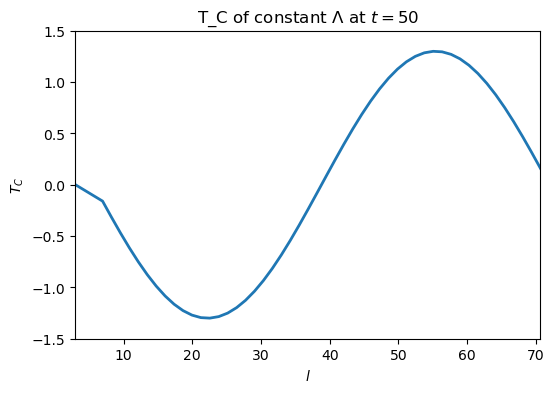

In [16]:
# Animate the data from 2D heatmap
fig, ax = plt.subplots(figsize=(6,4))
ax.set_xlim(all_coords[0], all_coords[-1])
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel(r'$l$')
ax.set_ylabel(r'$T_C$')

line, = ax.plot([], [], lw=2)
title = ax.set_title('')

def init():
    line.set_data([], [])
    return (line, title)

def animate(i):
    line.set_data(all_coords, T_C_array[i])
    title.set_text(f'T_C of constant $\\Lambda$ at $t={t[i]:d}$')
    return (line, title)

ani = animation.FuncAnimation(
    fig, animate, init_func=init,
    frames=len(t), interval=100, blit=True
)

writer = FFMpegWriter(
    fps=10,
    metadata=dict(title='T_C vs l of a sperm evolving from straight to circular'),
    bitrate=1800
)

ani.save('T_C_l_t.mp4', writer=writer, dpi=200)

In [17]:
@jax.jit
def calculate_sigma(radius: float
                   ) -> tuple: # (2, )
    """
    Compute the Gaussian widths used in FCM from the particle radius.

    Parameters
    ----------
    radius : self-explanatory

    Returns
    -------
    sigma_D : The translational Gaussian width
    sigma_T : The rotational Gaussian width
    """
    sigma_D = radius / jnp.sqrt(jnp.pi)
    sigma_T = radius / ( (6 * jnp.sqrt(jnp.pi)) ** (1/3) )
    return sigma_D, sigma_T

In [18]:
@lru_cache(maxsize=4)
def _get_fft_kernels(N_x, N_y, sigma_D, sigma_T, L_x, L_y):
    """
    Build and cache the Fourier‐space Gaussian kernels for FCM spreading.

    Parameters
    ----------
    N_x, N_y : integers
        Number of grid points in each axis
    sigma_D, sigma_T: floats
        Gaussian envelope sizes for force and torque respectively.
    L_x, L_y : floats
        Dimensions of the simulation domain
    
    Returns
    -------
    Ghat_D, Ghat_T: JAX arrays, shape (N_x, N_y)
        Fourier-space Gaussian kernels for force and torque spreading respectively.
    """
    # grid spacings
    dx, dy = L_x / N_x, L_y / N_y

    # small Gaussian in physical space
    def make_G(sigma):
        k = int(np.ceil(6 * sigma / dx)) | 1 # Use bitwise operation to ensure that k is odd
        g = np.linspace(-3*sigma, 3*sigma, k)
        X, Y = np.meshgrid(g, g, indexing='ij')
        return np.exp(-(X**2 + Y**2) / (2*sigma**2)) / (2 * np.pi * sigma**2)

    GD = make_G(sigma_D)
    GT = make_G(sigma_T)

    # gradient of GT for torque kernel
    g1d = np.linspace(-3*sigma_T, 3*sigma_T, GT.shape[0])
    X, Y = np.meshgrid(g1d, g1d, indexing='ij')
    gx = -X * GT / (sigma_T**2)
    gy = -Y * GT / (sigma_T**2)
    Gc = gy + 1j * (-gx)

    # embed small kernels into full grid and FFT
    def embed_fft(Gsmall):
        Gfull = np.zeros((N_x, N_y), dtype=np.complex128)
        sx = (N_x - Gsmall.shape[0]) // 2
        sy = (N_y - Gsmall.shape[1]) // 2
        Gfull[sx:sx+Gsmall.shape[0], sy:sy+Gsmall.shape[1]] = Gsmall.astype(np.complex128)
        Gfull = np.fft.ifftshift(Gfull)
        return np.fft.fft2(Gfull)

    Ghat_D = embed_fft(GD)
    Ghat_T = embed_fft(Gc)

    return jnp.array(Ghat_D), jnp.array(Ghat_T)

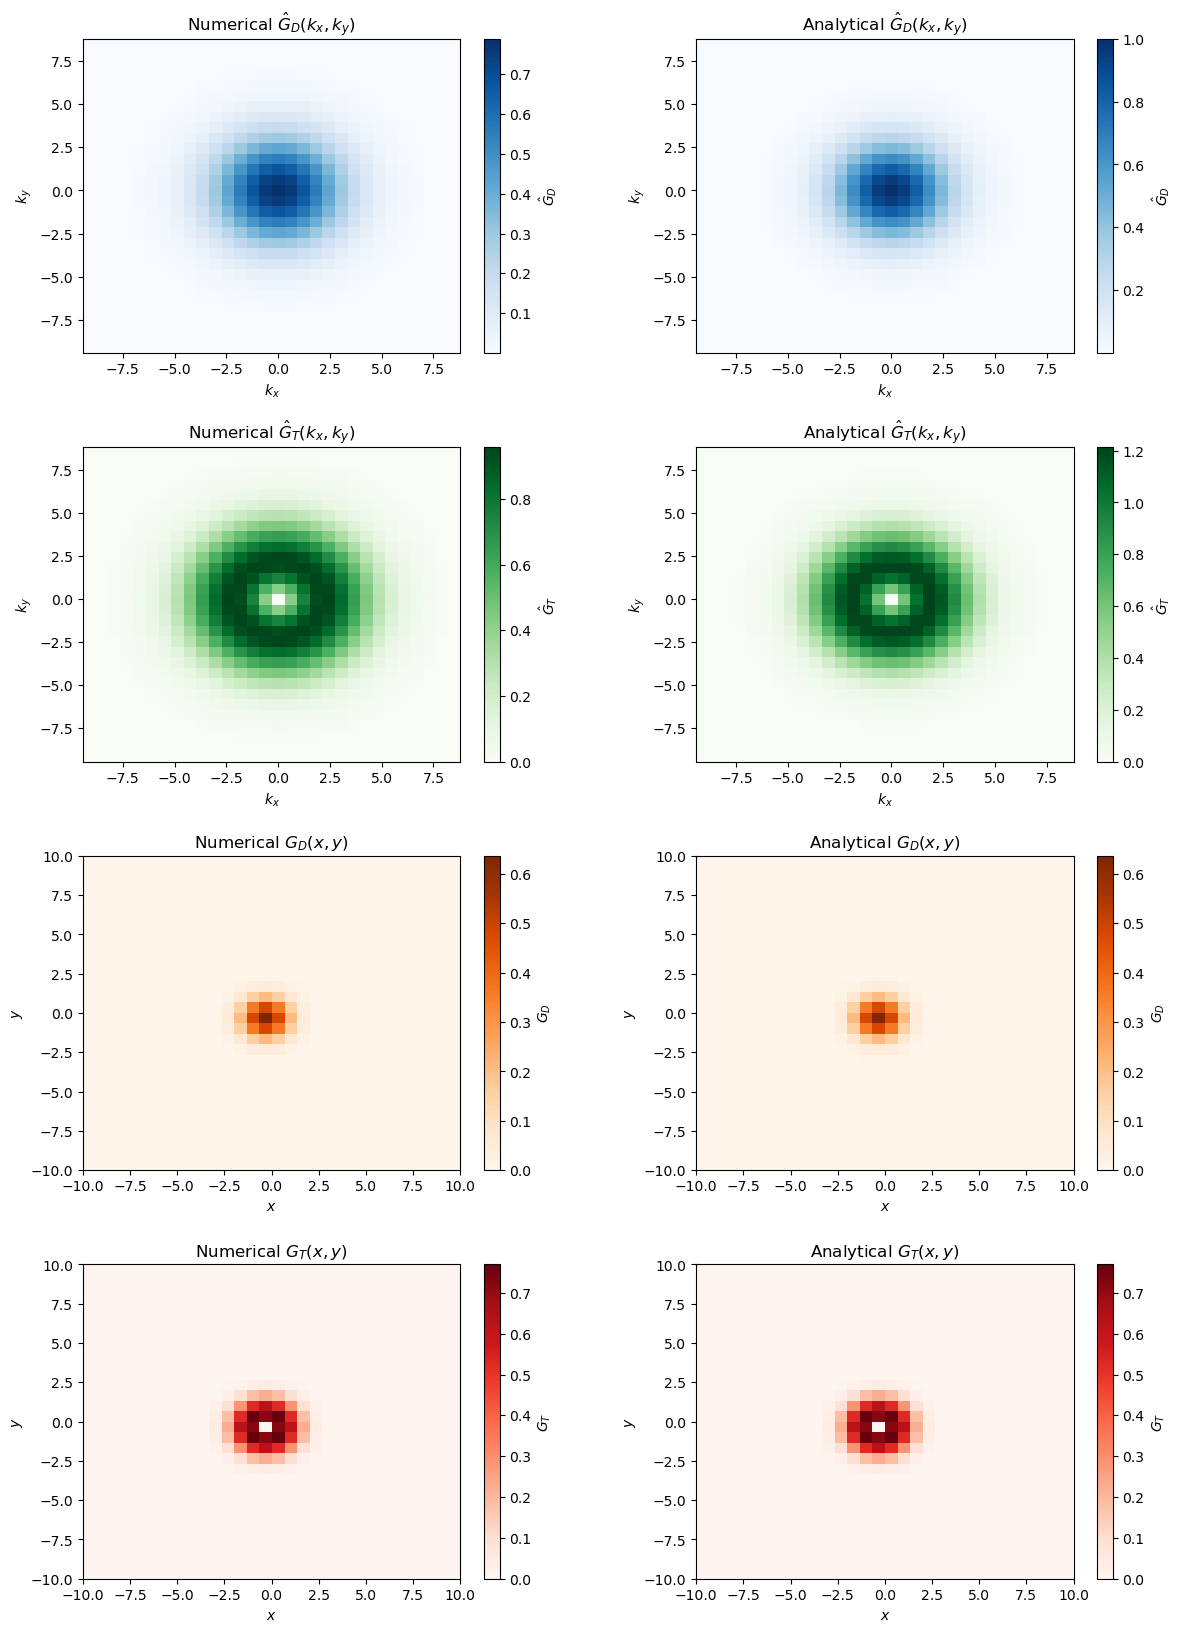

In [19]:
# Check _get_fft_kernels function
fig, ax = plt.subplots(4, 2, figsize=(14, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

N_x = N_y = 30
sigma_D = sigma_T = 0.5
L_x = L_y = 10
dx = dy = L_x / N_x
Ghat_D, Ghat_T = _get_fft_kernels(N_x, N_y, sigma_D, sigma_T, L_x, L_y)
kx = np.fft.fftfreq(N_x, d=L_x/N_x)*2*np.pi
ky = np.fft.fftfreq(N_y, d=L_y/N_y)*2*np.pi
kx = np.fft.fftshift(kx)
ky = np.fft.fftshift(ky)
KX, KY = np.meshgrid(kx, ky, indexing='ij')
GD_ifft = np.abs(np.fft.ifft2(Ghat_D))
GD_ifft = np.fft.fftshift(GD_ifft)
GT_ifft = np.abs(np.fft.ifft2(Ghat_T))
GT_ifft = np.fft.fftshift(GT_ifft)
Ghat_D = np.fft.fftshift(Ghat_D)
Ghat_T = np.fft.fftshift(Ghat_T)

# Numerical vs analytical fourier space test for force gaussian spread
im = ax[0, 0].imshow(dx*dy*np.abs(Ghat_D).T,
            extent=[kx[0], kx[-1], ky[0], ky[-1]],
    cmap='Blues',
    aspect='auto',
    origin='lower')
ax[0, 0].set_title(r"Numerical $\hat{G}_D(k_x, k_y)$")
ax[0, 0].set_xlabel(r'$k_x$')
ax[0, 0].set_ylabel(r'$k_y$')
cbar = fig.colorbar(im, ax=ax[0, 0])
cbar.set_label(r'$\hat{G}_D$')

im = ax[0, 1].imshow(np.exp(-0.5*(KX**2+KY**2)*sigma_D**2).T,
            extent=[kx[0], kx[-1], ky[0], ky[-1]],
    cmap='Blues',
    aspect='auto',
    origin='lower')
ax[0, 1].set_title(r"Analytical $\hat{G}_D(k_x, k_y)$")
ax[0, 1].set_xlabel(r'$k_x$')
ax[0, 1].set_ylabel(r'$k_y$')
cbar = fig.colorbar(im, ax=ax[0, 1])
cbar.set_label(r'$\hat{G}_D$')

# Numerical vs analytical fourier space test for torque gaussian spread
im = ax[1, 0].imshow(dx*dy*np.abs(Ghat_T).T,
            extent=[kx[0], kx[-1], ky[0], ky[-1]],
    cmap='Greens',
    aspect='auto',
    origin='lower')
ax[1, 0].set_title(r"Numerical $\hat{G}_T(k_x, k_y)$")
ax[1, 0].set_xlabel(r'$k_x$')
ax[1, 0].set_ylabel(r'$k_y$')
cbar = fig.colorbar(im, ax=ax[1, 0])
cbar.set_label(r'$\hat{G}_T$')

im = ax[1, 1].imshow(np.sqrt(KX**2+KY**2)*np.exp(-0.5*(KX**2+KY**2)*sigma_T**2).T,
            extent=[kx[0], kx[-1], ky[0], ky[-1]],
    cmap='Greens',
    aspect='auto',
    origin='lower')
ax[1, 1].set_title(r"Analytical $\hat{G}_T(k_x, k_y)$")
ax[1, 1].set_xlabel(r'$k_x$')
ax[1, 1].set_ylabel(r'$k_y$')
cbar = fig.colorbar(im, ax=ax[1, 1])
cbar.set_label(r'$\hat{G}_T$')

def make_G(sigma):
    k = int(np.ceil(6 * sigma / dx)) | 1 # Use bitwise operation to ensure that k is odd
    g = np.linspace(-3*sigma, 3*sigma, k)
    X, Y = np.meshgrid(g, g, indexing='ij')
    return np.exp(-(X**2 + Y**2) / (2*sigma**2)) / (2 * np.pi * sigma**2)
GD = make_G(sigma_D)
GT = make_G(sigma_T)

def embed(Gsmall):
    Gfull = np.zeros((N_x, N_y))
    sx = (N_x - Gsmall.shape[0]) // 2
    sy = (N_y - Gsmall.shape[1]) // 2
    Gfull[sx:sx+Gsmall.shape[0], sy:sy+Gsmall.shape[1]] = Gsmall
    return Gfull
GD_full = embed(GD)
g1d = np.linspace(-3*sigma_T, 3*sigma_T, GT.shape[0])
X, Y = np.meshgrid(g1d, g1d, indexing='ij')
gx = -X * GT / (sigma_T**2)
gy = -Y * GT / (sigma_T**2)
grad_G = np.sqrt(gx**2 + gy**2)
GT_full = embed(grad_G)
    
# Numerical vs analytical real space test for force gaussian spread
im = ax[2, 0].imshow(GD_ifft.T,
            extent=[-L_x, L_x, -L_y, L_y],
    cmap='Oranges',
    aspect='auto',
    origin='lower')
ax[2, 0].set_title(r"Numerical $G_D(x, y)$")
ax[2, 0].set_xlabel(r'$x$')
ax[2, 0].set_ylabel(r'$y$')
cbar = fig.colorbar(im, ax=ax[2, 0])
cbar.set_label(r'$G_D$')

im = ax[2, 1].imshow(GD_full.T,
            extent=[-L_x, L_x, -L_y, L_y],
    cmap='Oranges',
    aspect='auto',
    origin='lower')
ax[2, 1].set_title(r"Analytical $G_D(x, y)$")
ax[2, 1].set_xlabel(r'$x$')
ax[2, 1].set_ylabel(r'$y$')
cbar = fig.colorbar(im, ax=ax[2, 1])
cbar.set_label(r'$G_D$')

# Numerical vs analytical real space test for torque gaussian spread
im = ax[3, 0].imshow(GT_ifft.T,
            extent=[-L_x, L_x, -L_y, L_y],
    cmap='Reds',
    aspect='auto',
    origin='lower')
ax[3, 0].set_title(r"Numerical $G_T(x, y)$")
ax[3, 0].set_xlabel(r'$x$')
ax[3, 0].set_ylabel(r'$y$')
cbar = fig.colorbar(im, ax=ax[3, 0])
cbar.set_label(r'$G_T$')

im = ax[3, 1].imshow(GT_full.T,
                     extent=[-L_x, L_x, -L_y, L_y],
                     cmap='Reds',
                     aspect='auto',
                     origin='lower')
ax[3, 1].set_title(r"Analytical $G_T(x, y)$")
ax[3, 1].set_xlabel(r'$x$')
ax[3, 1].set_ylabel(r'$y$')
cbar = fig.colorbar(im, ax=ax[3, 1])
cbar.set_label(r'$G_T$')

plt.show()

In [20]:
def make_fcm_spread(
    L_x:       float,
    L_y:       float,
    N_x:       int,
    N_y:       int,
    Ghat_D:    jnp.ndarray, # (N_x, N_y)
    Ghat_T:    jnp.ndarray # (N_x, N_y)
) -> Callable[[jnp.ndarray, jnp.ndarray, jnp.ndarray], jnp.ndarray]:
    """
    Build the jax version of fcm_spread function, with constant parameters as arguments.

    Parameters
    ----------
    L_x, L_y : Dimensions of the simulation domain
    N_x, N_y : Grid sizes
    Ghat_D, Ghat_T : Fourier space Gaussian envelopes for force and torque respectively

    Returns:
    fcm_spread : A function which computes the force and torque field after Gaussian spread.
    """
    @jax.jit
    def fcm_spread(
        F_seg:     jnp.ndarray,   # (N_flag, 2) or (1, 2)
        T_seg:     jnp.ndarray,   # (N_flag,)  or (1, )
        coords:    jnp.ndarray,   # (N_flag,2) or (1, 2)
    ) -> jnp.ndarray: # (N_x, N_y, 2)
        """
        Calculate the spread of FCM force & torque onto a periodic 2D grid using convolution theorem.
        The parameters here are not constant.

        Parameters
        ----------
        F_seg : Total force acting at the midpoint of each segment. Shape depends on working with head or tail segment.
        T_seg : Total torque acting at the midpoint of each segment.
        coords : Positions of the midpoint of each segment. Already corrected for periodic boundary conditions.
    
        Returns
        -------
        f : The x and y-components of the force and torque field after Gaussian spread.
        """

        dx, dy = L_x/N_x, L_y/N_y
    
        # map coords -> grid indices
        ix = jnp.mod(jnp.rint((coords[:,0] + 0.5*L_x)/dx).astype(int), N_x)
        iy = jnp.mod(jnp.rint((coords[:,1] + 0.5*L_y)/dy).astype(int), N_y)
    
        # scatter-add forces into complex grid
        Fc = jnp.zeros((N_x, N_y), jnp.complex128)
        Fc = Fc.at[ix, iy].add(F_seg[:,0] + 1j*F_seg[:,1])
    
        # scatter-add torques into real grid
        Tz = jnp.zeros((N_x, N_y), jnp.complex128)
        Tz = Tz.at[ix, iy].add(T_seg)
    
        # FFTs
        Fc_hat = jnp.fft.fft2(Fc)
        Tz_hat = jnp.fft.fft2(Tz)
    
        # apply kernels and inverse FFT
        fc = Fc_hat * Ghat_D + 0.5 * Tz_hat * Ghat_T
        f  = jnp.fft.ifft2(fc)
    
        return jnp.stack([f.real, f.imag], axis=-1)
    return fcm_spread

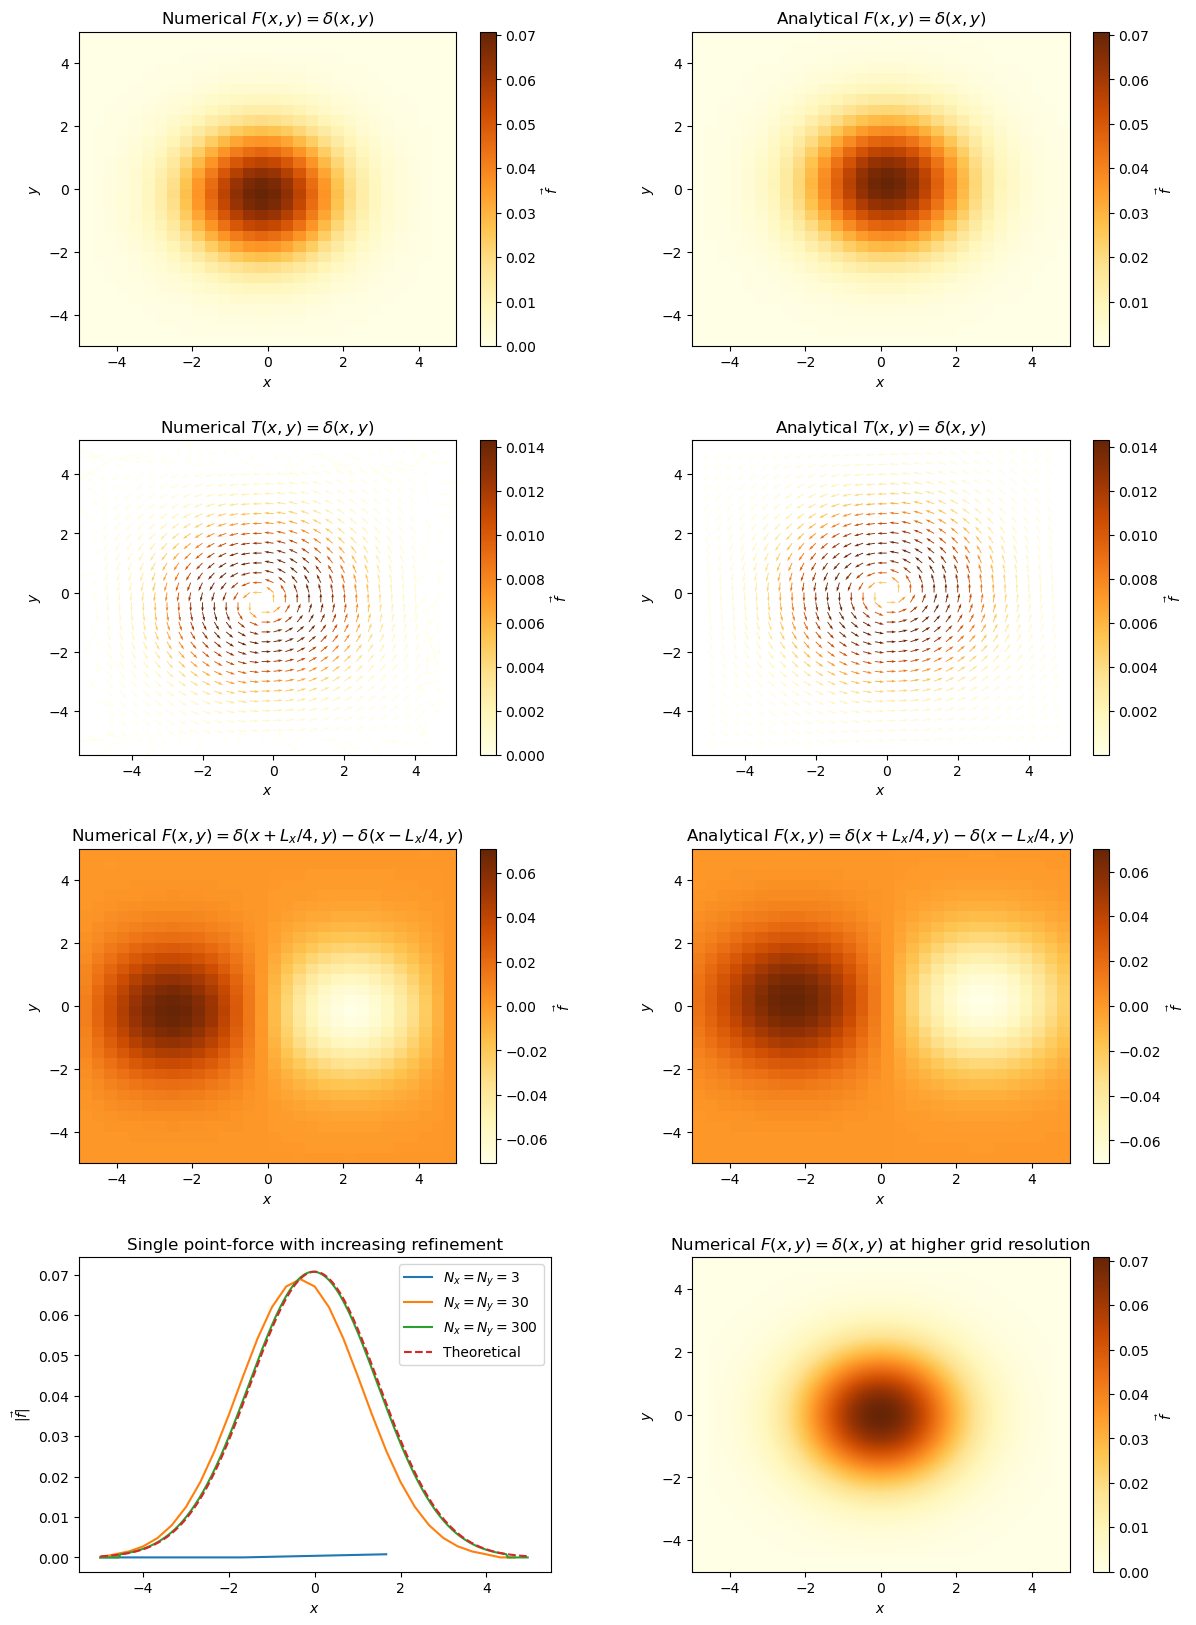

In [21]:
# Check fcm_spread function
fig, ax = plt.subplots(4, 2, figsize=(14, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

L_x = L_y = 10
N_x = N_y = 30
sigma_D = sigma_T = 1.5
Ghat_D, Ghat_T = _get_fft_kernels(N_x, N_y, sigma_D, sigma_T, L_x, L_y)
spread = make_fcm_spread(L_x, L_y, N_x, N_y, Ghat_D, Ghat_T)

# Single point-force heatmap
F_seg = jnp.array([[1.0, 0.0]])
T_seg = jnp.array([0.0])
coords = jnp.array([[0.0, 0.0]])
u = spread(F_seg, T_seg, coords)
im = ax[0, 0].imshow(u[...,0].T, 
                  extent=[-L_x/2, L_x/2, -L_y/2, L_y/2], 
                  origin='lower', 
                  aspect='auto', 
                  cmap='YlOrBr')
ax[0, 0].set_title(r'Numerical $F(x, y)=\delta(x, y)$')
ax[0, 0].set_xlabel(r'$x$')
ax[0, 0].set_ylabel(r'$y$')
cbar = fig.colorbar(im, ax=ax[0, 0])
cbar.set_label(r'$\vec{f}$')

x = np.linspace(-L_x/2, L_x/2, N_x, endpoint=False)
y = np.linspace(-L_y/2, L_y/2, N_y, endpoint=False)
X, Y = np.meshgrid(x, y, indexing='ij')
im = ax[0, 1].imshow((np.exp(-(X**2 + Y**2) / (2*sigma_D**2)) / (2*np.pi*sigma_D**2)).T, 
                  extent=[-L_x/2, L_x/2, -L_y/2, L_y/2], 
                  origin='lower', 
                  aspect='auto', 
                  cmap='YlOrBr')
ax[0, 1].set_title(r'Analytical $F(x, y)=\delta(x, y)$')
ax[0, 1].set_xlabel(r'$x$')
ax[0, 1].set_ylabel(r'$y$')
cbar = fig.colorbar(im, ax=ax[0, 1])
cbar.set_label(r'$\vec{f}$')

# Single point-torque heatmap
F_seg = jnp.array([[0.0, 0.0]])
T_seg = jnp.array([1.0])
coords = jnp.array([[0.0, 0.0]])
u = spread(F_seg, T_seg, coords)
mag = jnp.sqrt(u[..., 0]**2 + u[..., 1]**2)
qu = ax[1, 0].quiver(x, y,
                    u[..., 0].T/mag, u[..., 1].T/mag,
                    mag,
                    angles='xy',
                    cmap='YlOrBr',
                    scale=40)
ax[1, 0].set_title(r'Numerical $T(x, y)=\delta(x, y)$')
ax[1, 0].set_xlabel(r'$x$')
ax[1, 0].set_ylabel(r'$y$')
cbar = fig.colorbar(qu, ax=ax[1, 0])
cbar.set_label(r'$\vec{f}$')

factor = np.exp(-(X**2 + Y**2) / (2*sigma_T**2)) / (2*np.pi*sigma_T**4)
ux_exact = -0.5*Y*factor
uy_exact = 0.5*X*factor
mag = jnp.sqrt(ux_exact**2 + uy_exact**2)
qu = ax[1, 1].quiver(x, y,
                    ux_exact.T/mag, uy_exact.T/mag,
                    mag,
                    angles='xy',
                    cmap='YlOrBr',
                    scale=40)
ax[1, 1].set_title(r'Analytical $T(x, y)=\delta(x, y)$')
ax[1, 1].set_xlabel(r'$x$')
ax[1, 1].set_ylabel(r'$y$')
cbar = fig.colorbar(qu, ax=ax[1, 1])
cbar.set_label(r'$\vec{f}$')

# Two opposing point-forces heatmap
F_seg = jnp.array([[1.0, 0.0], [-1.0, 0.0]])
T_seg = jnp.array([0.0])
coords = jnp.array([[-L_x/4, 0.0], [L_x/4, 0.0]])
u = spread(F_seg, T_seg, coords)
im = ax[2, 0].imshow(u[...,0].T, 
                  extent=[-L_x/2, L_x/2, -L_y/2, L_y/2], 
                  origin='lower', 
                  aspect='auto', 
                  cmap='YlOrBr')
ax[2, 0].set_title(r'Numerical $F(x, y)=\delta(x+L_x/4, y)-\delta(x-L_x/4, y)$')
ax[2, 0].set_xlabel(r'$x$')
ax[2, 0].set_ylabel(r'$y$')
cbar = fig.colorbar(im, ax=ax[2, 0])
cbar.set_label(r'$\vec{f}$')

im = ax[2, 1].imshow((np.exp(-((X+L_x/4)**2 + Y**2) / (2*sigma_D**2)) / (2*np.pi*sigma_D**2)
                     - np.exp(-((X-L_x/4)**2 + Y**2) / (2*sigma_D**2)) / (2*np.pi*sigma_D**2)).T, 
                  extent=[-L_x/2, L_x/2, -L_y/2, L_y/2], 
                  origin='lower', 
                  aspect='auto', 
                  cmap='YlOrBr')
ax[2, 1].set_title(r'Analytical $F(x, y)=\delta(x+L_x/4, y)-\delta(x-L_x/4, y)$')
ax[2, 1].set_xlabel(r'$x$')
ax[2, 1].set_ylabel(r'$y$')
cbar = fig.colorbar(im, ax=ax[2, 1])
cbar.set_label(r'$\vec{f}$')

# Grid refinement check
F_seg = jnp.array([[1.0, 0.0]])
T_seg = jnp.array([0.0])
coords = jnp.array([[0.0, 0.0]])
N_list = [3*10**i for i in range(3)]
for i in range(3):
    x = np.linspace(-L_x/2, L_x/2, N_list[i], endpoint=False)
    y = np.linspace(-L_y/2, L_y/2, N_list[i], endpoint=False)
    Ghat_D, Ghat_T = _get_fft_kernels(N_list[i], N_list[i], sigma_D, sigma_T, L_x, L_y)
    spread = make_fcm_spread(L_x, L_y, N_list[i], N_list[i], Ghat_D, Ghat_T)
    u = spread(F_seg, T_seg, coords)
    ax[3, 0].plot(x, u[:, N_list[i]//2, 0], label=f'$N_x=N_y={N_list[i]}$')
x_exact = np.linspace(-L_x/2, L_x/2, 200)
u_exact = np.exp(-x_exact**2/(2*sigma_D**2))/(2*np.pi*sigma_D**2)
ax[3, 0].plot(x_exact, u_exact, '--', label='Theoretical')
ax[3, 0].legend()
ax[3, 0].set_title('Single point-force with increasing refinement')
ax[3, 0].set_xlabel(r'$x$')
ax[3, 0].set_ylabel(r'$|\vec{f}|$')

N_x = N_y = 300
Ghat_D, Ghat_T = _get_fft_kernels(N_x, N_y, sigma_D, sigma_T, L_x, L_y)
spread = make_fcm_spread(L_x, L_y, N_x, N_y, Ghat_D, Ghat_T)
im = ax[3, 1].imshow(u[...,0].T, 
                  extent=[-L_x/2, L_x/2, -L_y/2, L_y/2], 
                  origin='lower', 
                  aspect='auto', 
                  cmap='YlOrBr')
ax[3, 1].set_title(r'Numerical $F(x, y)=\delta(x, y)$ at higher grid resolution')
ax[3, 1].set_xlabel(r'$x$')
ax[3, 1].set_ylabel(r'$y$')
cbar = fig.colorbar(im, ax=ax[3, 1])
cbar.set_label(r'$\vec{f}$')

plt.show()

In [22]:
@partial(jax.jit, static_argnums=(1, 2))
def sperm_coordinates_pbc(seg_pos: jnp.ndarray, # (1, 2) or (N_flag, 2)
                          L_x: float,
                          L_y: float) -> jnp.ndarray: # (1, 2) or (N_flag, 2)
    """
    Apply periodic-boundary corrections to 2D segment positions.

    Parameters
    ----------
    seg_pos : Midpoint coordinates of each segment. Shape is dependent on head or tail.
    L_x, L_y : box lengths in x and y.

    Returns
    -------
    seg_pos : Corrected midpoint coordinates of each segment.
    """
    # split out
    x = seg_pos[:, 0]
    y = seg_pos[:, 1]

    # shift x into (–L_x/2, L_x/2]
    half_x = 0.5 * L_x
    x = jnp.where(x >=  half_x, x - L_x, x)
    x = jnp.where(x <  -half_x, x + L_x, x)

    # shift y into (–L_y/2, L_y/2]
    half_y = 0.5 * L_y
    y = jnp.where(y >=  half_y, y - L_y, y)
    y = jnp.where(y <  -half_y, y + L_y, y)

    # assemble back
    seg_pos = seg_pos.at[:, 0].set(x)
    seg_pos = seg_pos.at[:, 1].set(y)
    return seg_pos

In [132]:
@lru_cache(maxsize=2)
def _get_k_grids(N_x: int, N_y: int, L_x: float, L_y: float):
    """
    Build and cache the (k_x, k_y, inv_k2) arrays for a given grid and box size.

    Parameters
    ----------
    N_x, N_y : Number of grid points in x and y-axis.
    L_x, L_y : Grid dimensions

    Returns
    -------
    k_x, k_y, inv_k2 : jnp.array(float64), shape (N_x, N_y)
        k_x, k_y are the wavenumbers along x and y-axis.
        inv_k2 is the reciprocal of the wavenumber magnitude.
    """
    # 1D frequencies (on host)
    fx = jnp.fft.fftfreq(N_x)  # [0, 1/N_x, …, -(1/N_x), …]
    fy = jnp.fft.fftfreq(N_y)
    kx_1d = (2 * jnp.pi * N_x / L_x) * fx
    ky_1d = (2 * jnp.pi * N_y / L_y) * fy

    # Expand to 2D
    k_x, k_y = jnp.meshgrid(kx_1d, ky_1d, indexing='ij')  # (N_x, N_y)
    k2 = k_x**2 + k_y**2

    # avoid divide‐by‐zero at k=0
    inv_k2 = jnp.where(k2 > 1e-16, 1.0 / k2, 0.0)

    # promote to float64
    return k_x.astype(jnp.float64), k_y.astype(jnp.float64), inv_k2.astype(jnp.float64)

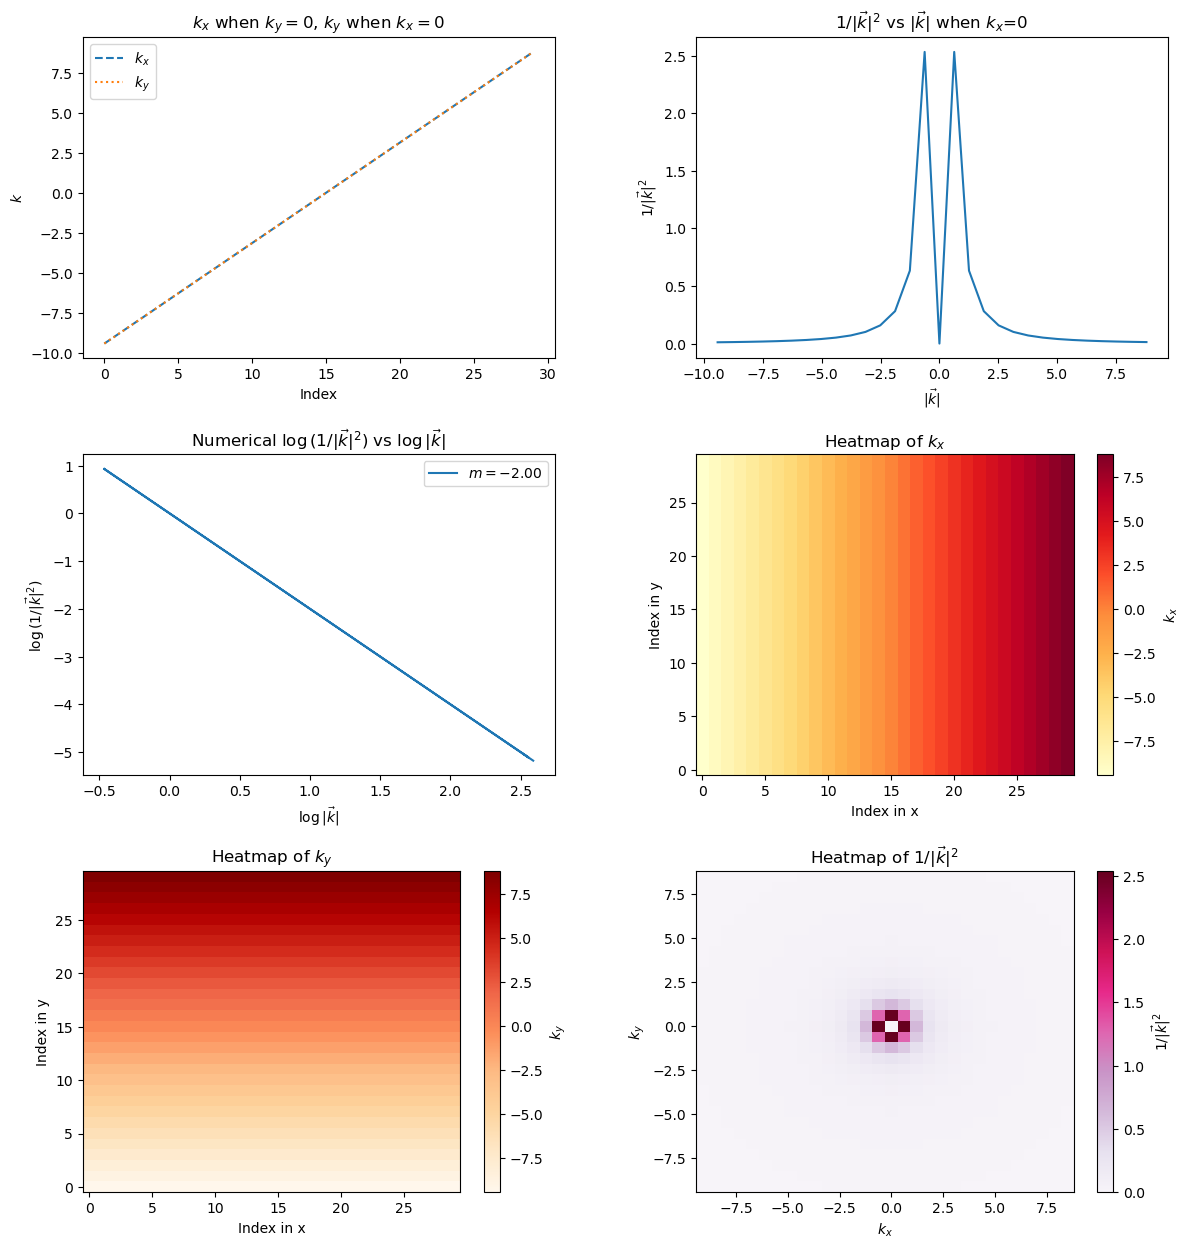

In [133]:
# Check fcm_spread function
fig, ax = plt.subplots(3, 2, figsize=(14, 15))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

N_x = N_y = 30
L_x = L_y = 10
# Axis slices of each field
k_x, k_y, inv_k2 = _get_k_grids(N_x, N_y, L_x, L_y)
k_x = jnp.fft.fftshift(k_x)
k_y = jnp.fft.fftshift(k_y)
inv_k2 = jnp.fft.fftshift(inv_k2)
ax[0, 0].plot(k_x[:, N_y//2], '--', label=r'$k_x$')
ax[0, 0].plot(k_y[N_x//2], ':', label=r'$k_y$')
ax[0, 0].legend()
ax[0, 0].set_title(r'$k_x$ when $k_y=0$, $k_y$ when $k_x=0$')
ax[0, 0].set_xlabel('Index')
ax[0, 0].set_ylabel(r'$k$')

ax[0, 1].plot(k_y[N_x//2], inv_k2[N_x//2])
ax[0, 1].set_title(r'$1/|\vec{k}|^2$ vs $|\vec{k}|$ when $k_x$=0')
ax[0, 1].set_xlabel(r'$|\vec{k}|$')
ax[0, 1].set_ylabel(r'$1/|\vec{k}|^2$')

# Radial profile of 1/k^2
k = jnp.sqrt(k_x**2 + k_y**2)
x = jnp.log(k.ravel())
y = jnp.log(inv_k2.ravel())
grad = (y[-1] - y[0]) / (x[-1] - x[0])
ax[1, 0].plot(x, y, label=f'$m={grad:.2f}$')
ax[1, 0].legend()
ax[1, 0].set_title(r'Numerical $\log{(1/|\vec{k}|^2)}$ vs $\log{|\vec{k}|}$')
ax[1, 0].set_xlabel(r'$\log{|\vec{k}|}$')
ax[1, 0].set_ylabel(r'$\log{(1/|\vec{k}|^2)}$')

# 2D heatmaps
im = ax[1, 1].imshow(k_x.T,  
                     origin='lower',
                     aspect='auto',
                     cmap='YlOrRd')
ax[1, 1].set_title(r'Heatmap of $k_x$')
ax[1, 1].set_xlabel('Index in x')
ax[1, 1].set_ylabel('Index in y')
cbar = fig.colorbar(im, ax=ax[1, 1])
cbar.set_label(r'$k_x$')

im = ax[2, 0].imshow(k_y.T,  
                     origin='lower',
                     aspect='auto',
                     cmap='OrRd')
ax[2, 0].set_title(r'Heatmap of $k_y$')
ax[2, 0].set_xlabel('Index in x')
ax[2, 0].set_ylabel('Index in y')
cbar = fig.colorbar(im, ax=ax[2, 0])
cbar.set_label(r'$k_y$')

im = ax[2, 1].imshow(inv_k2.T,
                     extent = [k_x[0, 0], k_x[-1, -1], k_y[0, 0], k_y[0, -1]],
                     origin='lower',
                     aspect='auto',
                     cmap='PuRd')
ax[2, 1].set_title(r'Heatmap of $1/|\vec{k}|^2$')
ax[2, 1].set_xlabel(r'$k_x$')
ax[2, 1].set_ylabel(r'$k_y$')
cbar = fig.colorbar(im, ax=ax[2, 1])
cbar.set_label(r'$1/|\vec{k}|^2$')

plt.show()

In [134]:
@partial(jax.jit, static_argnums=tuple(range(1, 4)))
def solve_stokes(f: jnp.ndarray, # (N_x, N_y, 2)
                 L_x: float,
                 L_y: float,
                 eta: float
                ) -> jnp.ndarray: # (N_x, N_y, 2)
    """
    JAX‐ified Stokes solver via FCM/FFT on a periodic 2D box.

    Parameters
    ----------
      f : Force field on the grid after Gaussian spread
      L_x, L_y : Dimensions of simulation domain
      eta : Fluid viscosity

    Returns
    -------
      u : Real‐space fluid velocity on the same grid as f
    """
    
    # split components
    f_x = f[..., 0]
    f_y = f[..., 1]

    N_x, N_y = f_x.shape

    # get precomputed wavenumber arrays
    k_x, k_y, inv_k2 = _get_k_grids(N_x, N_y, L_x, L_y)

    # forward FFT
    fhat_x = jnp.fft.fft2(f_x)
    fhat_y = jnp.fft.fft2(f_y)

    # projection in Fourier space
    k_dot_f = k_x * fhat_x + k_y * fhat_y    # (N_x, N_y), complex
    factor  = inv_k2 / eta                   # real
    temp    = k_dot_f * inv_k2               # (k·f)/|k|^2, zero at k=0
    uhat_x  = (fhat_x - k_x * temp) * factor
    uhat_y  = (fhat_y - k_y * temp) * factor

    # inverse FFT → real space
    u_x = jnp.real(jnp.fft.ifft2(uhat_x)) 
    u_y = jnp.real(jnp.fft.ifft2(uhat_y))

    # stack back to (N_x, N_y, 2)
    return jnp.stack([u_x, u_y], axis=-1)

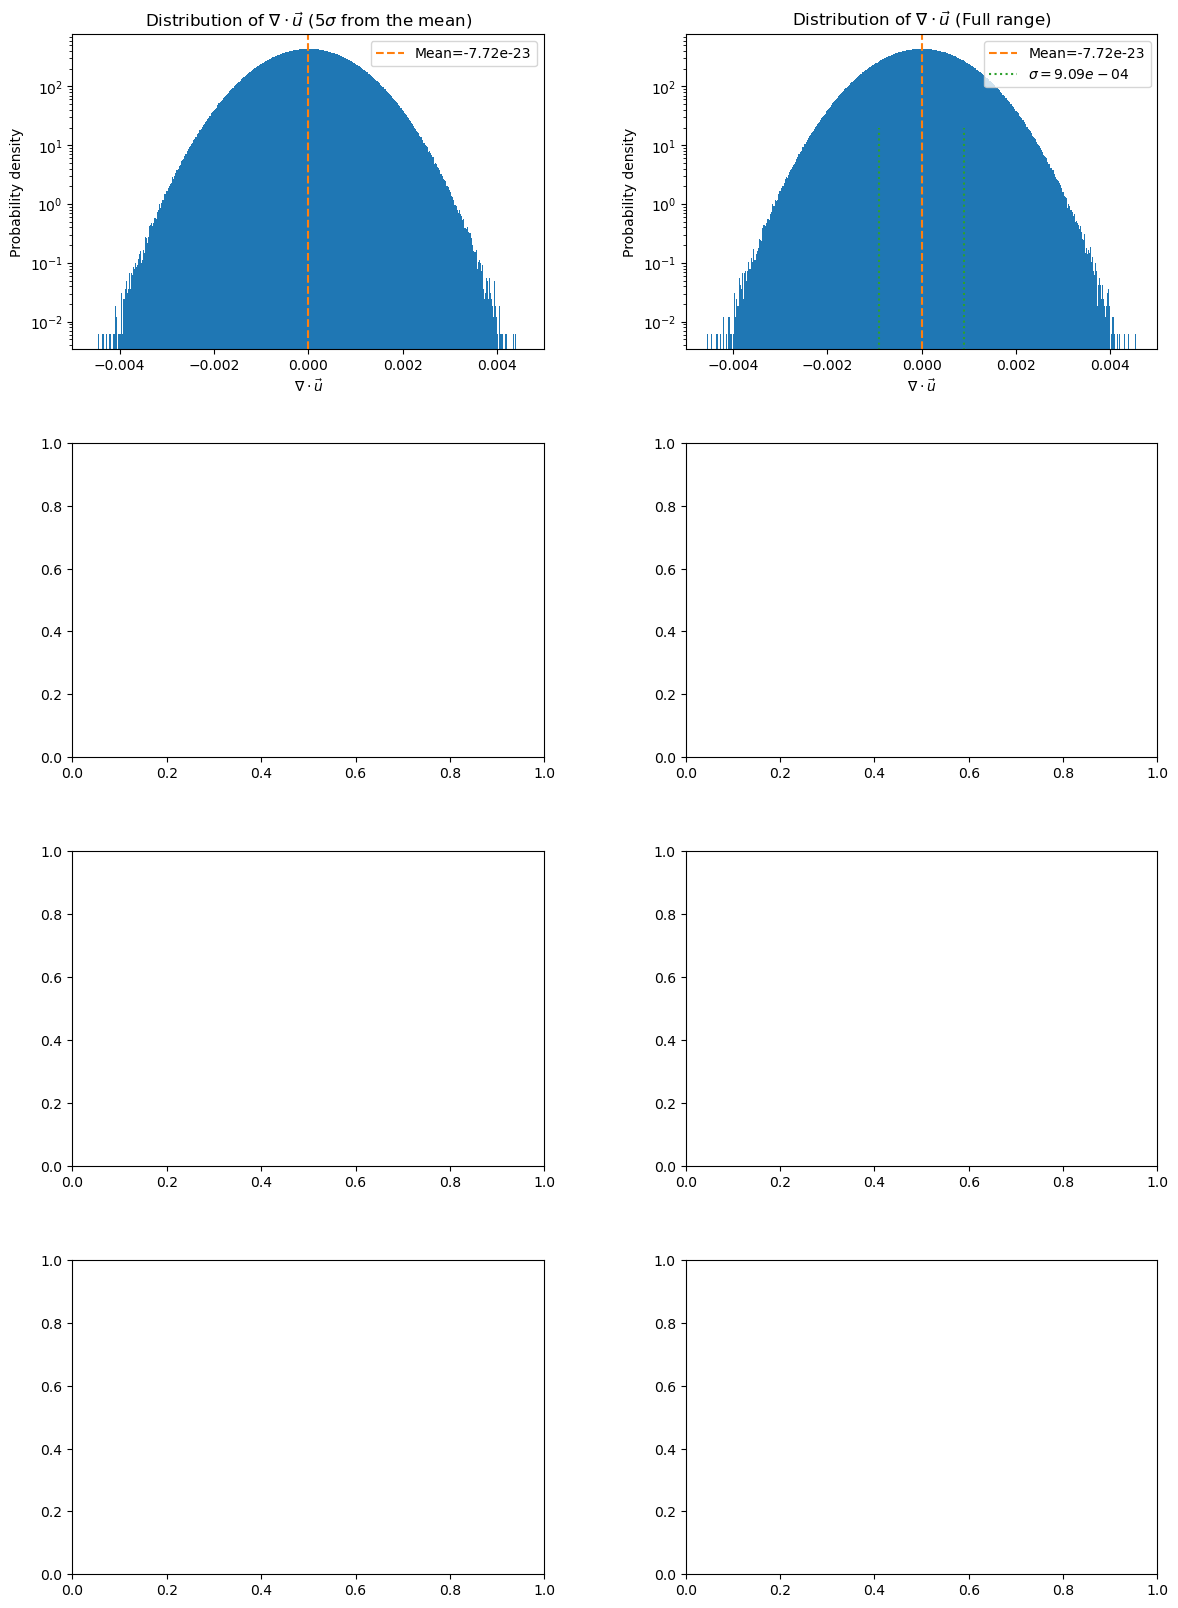

In [154]:
# Check solve_stokes function
fig, ax = plt.subplots(4, 2, figsize=(14, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Divergence-free check
N_x = N_y = 3000
L_x = L_y = 10
dx = dy = L_x / N_x
eta = 1
x = np.linspace(-L_x/2, L_x/2, N_x, endpoint=False)
y = np.linspace(-L_y/2, L_y/2, N_y, endpoint=False)
key = jax.random.key(22)
f = jax.random.uniform(key, shape=(N_x, N_y, 2), minval=-10, maxval=10)
u = np.array(solve_stokes(f, L_x, L_y, eta))
ux = u[..., 0]
uy = u[..., 1]
dux_dx = (np.roll(ux, -1, axis=0) - np.roll(ux, +1, axis=0)) / (2*dx)
duy_dy = (np.roll(uy, -1, axis=1) - np.roll(uy, +1, axis=1)) / (2*dy)
div_u = dux_dx + duy_dy
div_u_np = div_u.flatten()
mean_div = np.mean(div_u_np)
std_div = np.std(div_u_np)
max_abs = np.max(div_u_np)
ax[0, 0].hist(div_u_np, bins=500, 
              range=(mean_div-5*std_div, mean_div+5*std_div),
              density=True)
ax[0, 0].axvline(mean_div, color='C1', linestyle='--', label=f'Mean={mean_div:.2e}')
ax[0, 0].set_xlabel(r'$\nabla \cdot \vec{u}$')
ax[0, 0].set_ylabel('Probability density')
ax[0, 0].set_title(r'Distribution of $\nabla \cdot \vec{u}$ ($5\sigma$ from the mean)')
ax[0, 0].set_yscale('log')
ax[0, 0].legend()

ax[0, 1].hist(div_u_np, bins=500, 
              range=(-max_abs, max_abs),
              density=True)
ax[0, 1].axvline(mean_div, color='C1', linestyle='--', label=f'Mean={mean_div:.2e}')
ax[0, 1].vlines([mean_div-std_div, mean_div+std_div], 0, 20, color='C2', linestyle=':', label=f'$\\sigma={std_div:.2e}$')
ax[0, 1].set_xlabel(r'$\nabla \cdot \vec{u}$')
ax[0, 1].set_ylabel('Probability density')
ax[0, 1].set_title(r'Distribution of $\nabla \cdot \vec{u}$ (Full range)')
ax[0, 1].set_yscale('log')
ax[0, 1].legend()

plt.show()